# Training a U-Net with PyTorch on SageMaker
In this notebook you'll see how to train a U-Net with a synthetic dataset using SageMaker. We'll use a public implementation of the model, published to https://github.com/milesial/Pytorch-UNet. Our goal here is not to change the original code, but only apply minimal adjustments to point it to the correct directories used by SageMaker.

**Dataset**: We'll prepare a synthetic dataset for semantic segmentation using OpenCV. The dataset is basicaly a background noise with random geometric shapes rendered on top. The masks will correspond to the geometric shapes.

For this exercise, wel'll have only two classes in our dataset: 0 - Background, 1 - Shape

# 1) Clone the repo and adjust the training file for SageMaker

SageMaker uses the dir **/opt/ml/......** to manage files: datasets, checkpoints, logs, trained models, etc. So, we need to change some hardcoded parameters in the training script to point it to the correct directories used by SageMaker

In [ ]:
import os
import shutil
if os.path.isdir('src'): shutil.rmtree('src')
!git clone https://github.com/milesial/Pytorch-UNet src && cd src && git checkout 2f62e6b

## Adjusting the paths to make it aligned with SageMaker
!sed -i "s#'./data/imgs/'#'/opt/ml/input/data/train/imgs/'#" src/train.py
!sed -i "s#'./data/masks/'#'/opt/ml/input/data/train/masks/'#" src/train.py
!sed -i "s#'./checkpoints/'#'/opt/ml/model/'#" src/train.py
## Only the last checkpoint will be kept
## For a more elaborated mechanis, you'll need to edit src/train.py
!sed -i "s#'checkpoint_epoch{}.pth'.format(epoch)#'model.pt'#" src/train.py

## 3) Initialize SageMaker session

In [3]:
import cv2
import sagemaker
import numpy as np

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

sess = sagemaker.Session()
bucket = sess.default_bucket()
region = sess.boto_region_name
role = sagemaker.get_execution_role()

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {bucket}")
print(f"sagemaker session region: {region}")

2.132.0
You need to upgrade or restart the kernel if you already upgraded
sagemaker role arn: arn:aws:iam::715445047862:role/MachineLearningHost
sagemaker bucket: sagemaker-us-east-1-715445047862
sagemaker session region: us-east-1


## 4) Generate a synthetic dataset

In [ ]:
import os
import cv2
import math
import time
import shutil
import numpy as np

class GeometryDatasetGenerator(object):
    def __init__(self):
        self.triangle = np.array([[-1,math.sqrt(2)/2],[1,math.sqrt(2)/2],[0,-math.sqrt(2)/2]], dtype=np.float32)
        self.square = np.array([[-1,1],[-1,-1],[1,-1],[1,1]], dtype=np.float32)
        self.circle = None
        self.geometries = [self.triangle, self.square, self.circle]
        self.colors = [(np.random.randint(1, 255),np.random.randint(1, 255),np.random.randint(1, 255)) for i in self.geometries]
        self.class_ids = list(range(1, len(self.geometries)+1))
        
    def __gen_object__(self, base_obj, cx,cy, angle, scale):
        rotation = np.array([[math.cos(angle), -math.sin(angle)],[math.sin(angle), math.cos(angle)]], dtype=np.float32)
        obj = np.dot(base_obj, rotation.T)
        obj *= scale
        obj += [cx,cy]
        return obj.astype(np.int32)
    
    def __render_object__(self, img, mask, obj_id, cx, cy, angle, scale):
        base_obj = self.geometries[obj_id]
        if not base_obj is None:            
            obj = self.__gen_object__(base_obj, cx,cy,angle,scale)
            cv2.fillPoly(img, [obj], self.colors[obj_id])
            cv2.fillPoly(mask, [obj], self.class_ids[obj_id])
        else:
            cv2.circle(img, (cx,cy), scale, self.colors[obj_id], -1)
            cv2.circle(mask, (cx,cy), scale, self.class_ids[obj_id], -1)

    def gen_sample(self, width=640, height=480, num_objects=20, sigma=20):
        # generate an image with background noise
        img = np.random.normal(scale=sigma, size=(height, width, 3))
        img -= np.amin(img)
        img /= np.amax(img)
        img = (img * 255).astype(np.uint8)
        
        mask = np.zeros((height, width), dtype=np.uint8)
        for i in range(20):
            scale = np.random.randint(width//50, width//20)
            cx,cy = np.random.randint(1, width),np.random.randint(1, height)
            angle = math.radians(np.random.randint(1,100))
            obj_id = np.random.randint(0,len(self.geometries))
            self.__render_object__(img, mask, obj_id, cx,cy,angle,scale)
        return img,mask

    def gen_dataset(self, num_samples, width, height, num_objects, path):
        if not os.path.isdir(path):
            os.makedirs(os.path.join(path, 'imgs'), exist_ok=True)
            os.makedirs(os.path.join(path, 'masks'), exist_ok=True)
        t = time.time()
        for i in range(num_samples):
            img,mask = self.gen_sample(width,height,num_objects)
            cv2.imwrite(os.path.join(path, 'imgs', f'sample_{i:04d}.jpg'), img)
            cv2.imwrite(os.path.join(path, 'masks', f'sample_{i:04d}.png'), mask)
        print(f"Elapsed time: {(time.time()-t)*1000}")
        return True

generator = GeometryDatasetGenerator()
data_path = 'data'
num_samples = 2500
num_objects_per_sample = 35
if os.path.isdir(data_path): shutil.rmtree(data_path)
generator.gen_dataset(num_samples, 480*2, 270*2, num_objects_per_sample, data_path)

### 4.1) Visualize a sample of the dataset

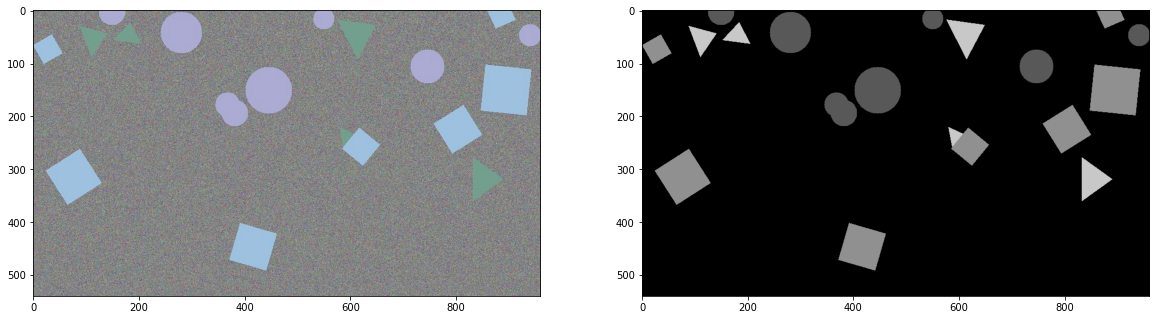

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

idx = np.random.randint(0, num_samples)
img = cv2.imread(f'{data_path}/imgs/sample_{idx:04d}.jpg')
mask = cv2.imread(f'{data_path}/masks/sample_{idx:04d}.png') * 200

f, axarr = plt.subplots(1,2, figsize=(20,10))

axarr[0].imshow(img)
axarr[1].imshow(mask)

### 4.2) Upload the dataset to S3

In [ ]:
s3_train_uri = sess.upload_data(path='data/', key_prefix='datasets/circles')
print(f"Train s3 uri: {s3_train_uri}")

## 5) Train our model using a SageMaker Estimator for PyTorch

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train.py", # Specify your train script
    source_dir="src",
    role=role,
    sagemaker_session=sess,
    instance_count=1,
    instance_type='ml.g4dn.2xlarge',    
    disable_profiler=True,
    output_path=f"s3://{bucket}/output",
    framework_version='1.13.1',
    py_version='py39',
    
    volume_size = 64,
    hyperparameters={
        "learning-rate": 0.0003,
        "epochs": 20,
        "batch-size": 8,
        "classes": 4,
        "validation": 30
    },
    metric_definitions=[
        {'Name': 'train:loss', 'Regex': 'loss \(batch\)=(\S+)\]'},
        {'Name': 'dice:score', 'Regex': 'Validation Dice score: (\S+).'}
    ]
)

In [ ]:
estimator.fit({"train": s3_train_uri})

## 6) Create a custom inference file SageMaker will use to load/run our model

In [ ]:
%%writefile src/inference.py
import os
import io
import cv2
import torch
import numpy as np
from unet import UNet
from PIL import Image
from predict import predict_img, mask_to_image

scale = 0.5
num_classes=4
mask_threshold = 0.5
mask_values = list(range(num_classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_fn(model_dir, context=None):
    global device, mask_values,num_classes
    model_path = os.path.join(model_dir, 'model.pt')
    print(f"Model path: {model_path}")
    model = UNet(n_channels=3, n_classes=num_classes, bilinear=False).to(device).eval()    
    state_dict = torch.load(model_path)
    state_dict.pop('mask_values', mask_values)    
    model.load_state_dict(state_dict)
    return model

def input_fn(request_body, request_content_type, context=None):
    if request_content_type != 'image/jpeg':
        raise Exception(f"Unsupported mime type: {request_content_type}. Supported: image/jpeg")
    return Image.open(io.BytesIO(request_body))

def predict_fn(input_image, model, context=None):    
    global device, scale, mask_threshold, mask_values
    mask = predict_img(
        net=model, full_img=input_image, scale_factor=scale, out_threshold=mask_threshold, device=device
    )
    return mask

def output_fn(mask, accept, context=None):
    if accept!='image/jpeg':
        raise Exception(f'Invalid data type. Expected image/jpeg, got {accept}')

    mask_img = np.array(mask_to_image(mask, mask_values))[..., np.newaxis].astype(np.uint8)
    return cv2.imencode(".jpg", mask_img)[1].tobytes()

## 7) Deploy a SageMaker real-time endpoint

In [ ]:
pytorch_model = estimator.create_model(
    entry_point="inference.py", # Specify your train script
    source_dir="src",
    role=role,    
)

In [ ]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.g4dn.2xlarge',
)

## 8) Now, we can invoke our model and run some experiments

In [ ]:
from sagemaker.serializers import DataSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer = DataSerializer(content_type='image/jpeg')
predictor.deserializer = BytesDeserializer(accept='image/jpeg')

Elapsed: 162.7490520477295ms


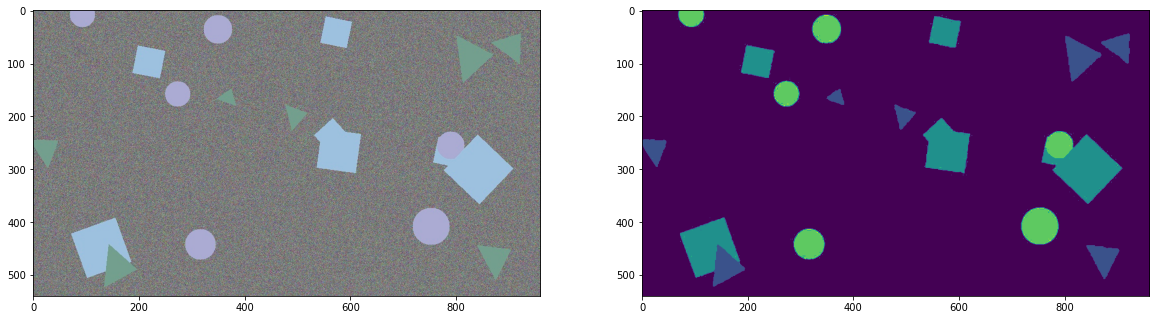

In [47]:
%matplotlib inline
import cv2
import time
import numpy as np
img_data = open(f'data/imgs/sample_{np.random.randint(0,10):04d}.jpg', 'rb').read()

img = cv2.imdecode(np.frombuffer(img_data, dtype=np.uint8), cv2.IMREAD_COLOR)
t = time.time()
mask = predictor.predict(img_data)
print(f"Elapsed: {(time.time()-t)*1000}ms")
mask = cv2.imdecode(np.frombuffer(mask, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)

f, axarr = plt.subplots(1,2, figsize=(20,10)) 

axarr[0].imshow(img)
axarr[1].imshow(mask)

## 9) Delete the endpoint

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()